In [1]:
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.metrics import r2_score as r2_score
from sklearn.metrics import mean_squared_error as mse

from itertools import product

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
plt.rcParams['figure.figsize'] = [18, 10]

## Importing Dataset

In [3]:
df = pd.read_csv("../../Dataset/Gold.csv")
df

,Open,Close,High,Low,Date
0,1302.910,1316.500,1318.910,1302.855,1/2/2018
1,1318.375,1318.875,1321.300,1307.710,1/3/2018
2,1313.105,1327.875,1327.875,1306.050,1/4/2018
3,1322.050,1319.590,1323.505,1313.910,1/5/2018
4,1321.050,1320.980,1322.210,1315.105,1/8/2018
...,...,...,...,...,...
2110,2352.200,2361.310,2363.460,2340.420,5/28/2024
2111,2361.390,2339.110,2361.790,2335.070,5/29/2024
2112,2338.880,2343.380,2351.090,2323.030,5/30/2024
2113,2343.340,2327.820,2359.580,2320.630,5/31/2024


In [4]:
df.dtypes

Open     float64
Close    float64
High     float64
Low      float64
Date      object
dtype: object

In [5]:
df = df[["Close"]]
df.reset_index(drop=True)

,Close
0,1316.500
1,1318.875
2,1327.875
3,1319.590
4,1320.980
...,...
2110,2361.310
2111,2339.110
2112,2343.380
2113,2327.820


In [6]:
df.head()

,Close
0,1316.500
1,1318.875
2,1327.875
3,1319.590
4,1320.980


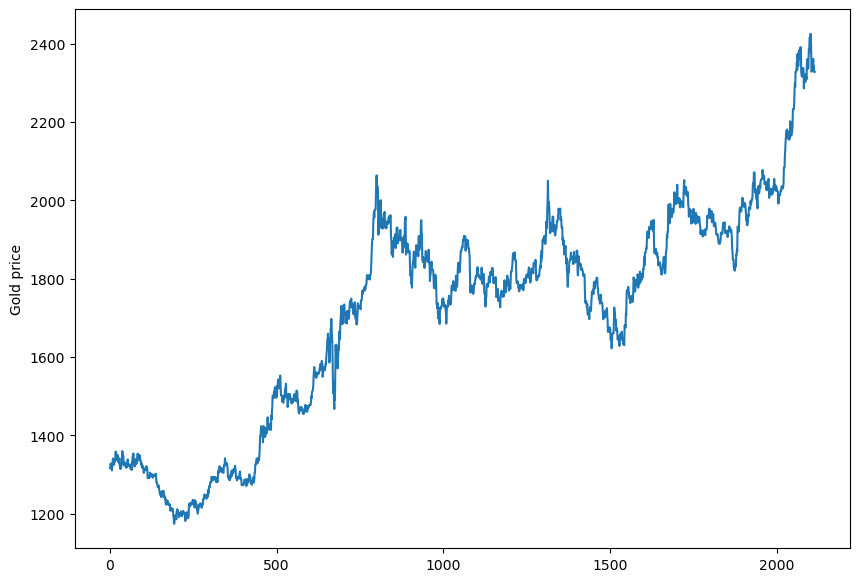

In [7]:
#Đồ thị giá đóng
df.Close.plot(figsize = (10, 7))
plt.ylabel("Gold price")
plt.show()


In [8]:
#train test split
train_size = int(0.6 * len(df))

train_df = df[:train_size]
test_df = df[train_size:]

In [9]:
model = ETSModel(
    train_df['Close'],
    error="mul",
    trend="add",
    seasonal="mul",
    damped_trend=False,
    seasonal_periods=90)

res = model.fit()
print(res.summary())

                                 ETS Results                                  
Dep. Variable:                  Close   No. Observations:                 1269
Model:                       ETS(MAM)   Log Likelihood               -4993.023
Date:                Thu, 06 Jun 2024   AIC                          10178.046
Time:                        15:25:57   BIC                          10672.060
Sample:                             0   HQIC                         10363.623
                               - 1269   Scale                            0.000
Covariance Type:               approx                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
smoothing_level         0.9999      0.027     37.498      0.000       0.948       1.052
smoothing_trend      9.999e-05        nan        nan        nan         nan         nan
smoothing_season

## FORECASTING

In [10]:
predicted = res.predict(start = len(train_df), end = len(train_df) + len(test_df) - 1)

In [11]:
mape = np.mean(np.abs(predicted - test_df['Close'])/np.abs(test_df['Close'])) *100
mse = np.mean(np.square(test_df['Close'] - predicted))
rmse = np.sqrt(mse)

print("Mean Absolute Percentage Error (MAPE):", mape)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)

Mean Absolute Percentage Error (MAPE): 4.8798330806016175
Mean Squared Error (MSE): 17146.95560806651
Root Mean Squared Error (RMSE): 130.94638447878776


In [12]:
# Quá trình tạo index predict 90 ngày tiếp theo
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+90, step=1)

# Predict the closing prices for the next 90 days
y_next_90_days = res.predict(start = len(df), end = len(df) + 90 - 1)

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 90 days:')
print(y_next_90_days)

Predicted closing prices for the next 90 days:
2115    2012.096190
2116    2014.490504
2117    2020.985306
2118    2021.312799
2119    2015.425954
           ...     
2200    2040.331303
2201    2038.352373
2202    2032.784668
2203    2029.052905
2204    2035.008955
Length: 90, dtype: float64


In [13]:
dt_train = np.append(train_df, predicted.iloc[0]) 

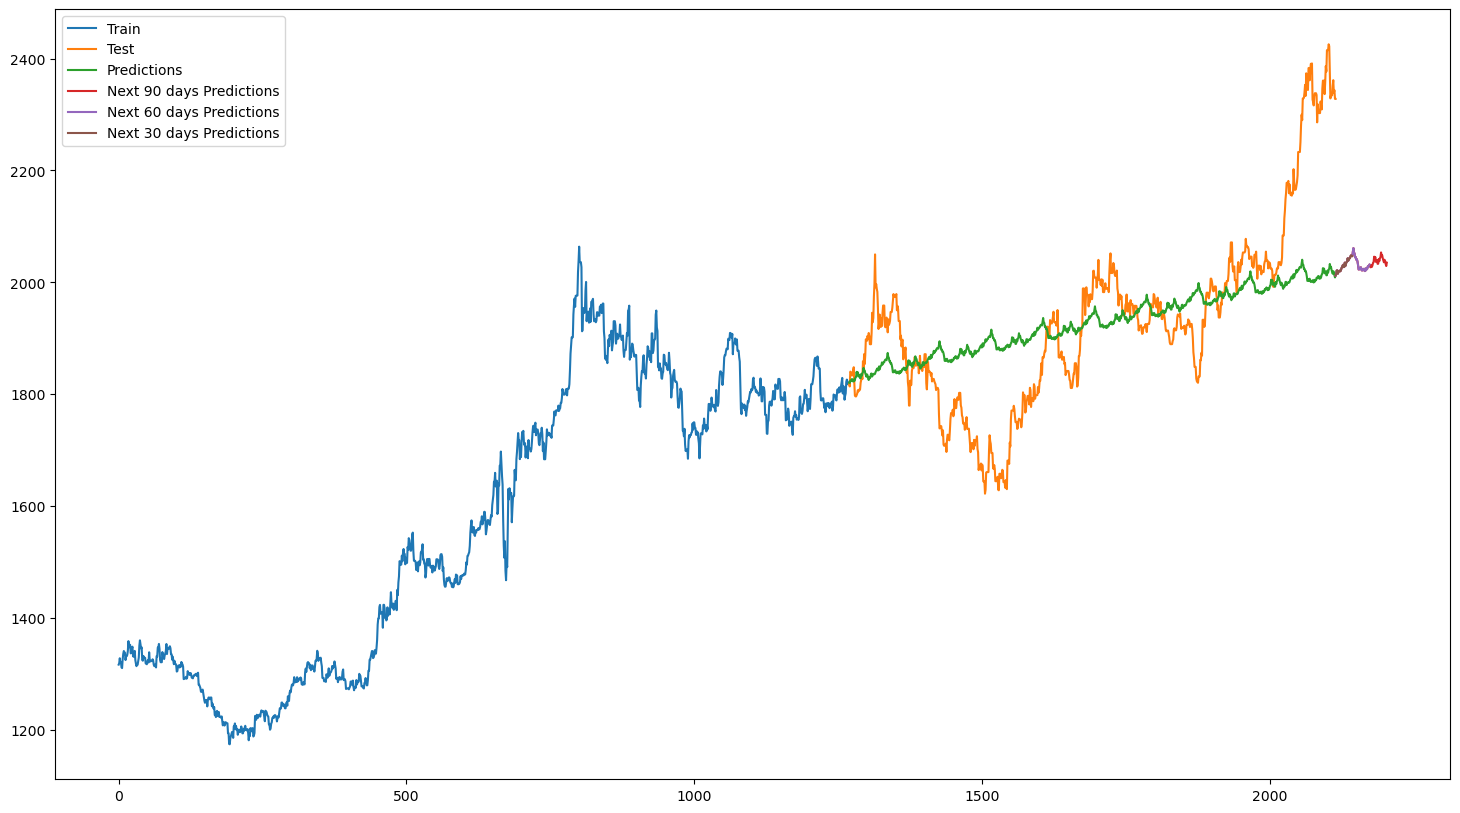

In [14]:
fig, ax = plt.subplots()

plt.plot(pd.RangeIndex(start=0, stop=len(dt_train), step=1), dt_train)
plt.plot(test_df.index, test_df)
plt.plot(test_df.index, predicted)
plt.plot(last_data,y_next_90_days)
plt.plot(pd.RangeIndex(start=last_index, stop=last_index+60, step=1),y_next_90_days[0:60])
plt.plot(pd.RangeIndex(start=last_index, stop=last_index+30, step=1),y_next_90_days[0:30])
plt.legend(['Train', 'Test', 'Predictions', 'Next 90 days Predictions', 'Next 60 days Predictions', 'Next 30 days Predictions'])
plt.show()
